In [1067]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.stats.power import TTestIndPower
import seaborn as sns
from scipy.stats import linregress

In [1068]:
# necessario creare una cartella dati fuori da questa
magistrale= pd.DataFrame(pd.read_excel("../dati/iscritti_magistrale_informatica.xls")) 
triennale= pd.DataFrame(pd.read_excel("../dati/iscritti_triennale_informatica.xls")) 
piani= pd.DataFrame(pd.read_excel("../dati/piani_informatica.xls"))

In [1069]:
# verifico di avere un campione sufficiente all'analisi

Z = 1.96  # Livello di confidenza del 95%
sigma = 10  # Deviazione standard stimata
E = 2  # Margine di errore desiderato

# Calcolo della dimensione del campione
n = (Z * sigma / E) ** 2
n = math.ceil(n)  # Arrotonda per eccesso al numero intero più vicino

print(f"Dimensione del campione necessaria: {n}")

Dimensione del campione necessaria: 97


In [1070]:
# percentuale donne in triennale: 14.4
print((triennale['GENERE'] == 'F').mean() * 100)

14.436363636363636


In [1071]:
# join triennale
pt = pd.merge(piani, 
              triennale[['PROGRESSIVO', 'CODCLA', 'GENERE', 'ANAC_INGRESSO', 'ANAC_USCITA','DATA_LAUREA','SITUAZIONE_FINALE','VOTO_LAUREA']], 
              how="right", 
              left_on=["PROGRESSIVO", "CODCLA"], 
              right_on=["PROGRESSIVO", "CODCLA"])

In [1072]:
# pulizia dati

# elimino in piani_triennali i valori in cui ho NaN in CODICE_INS e DECODIFICA_INS
pt.dropna(subset=['CODICE_INS', 'DECODIFICA_INS'], how='all', inplace=True)

# miglioro leggibilità
pt['CODCLA'] = pt['CODCLA'].astype(int)
pt['CODICE_INS'] = pt['CODICE_INS'].astype(int)
pt['VOTO'] = pt['VOTO'].astype(int)

# elimino colonna rindondante (codcla separa triennale e magistrale)
pt['CODCLA'].unique()
pt.drop(columns=['CODCLA'], inplace=True)

# elimino insegnamenti con meno di 50 partecipanti (molti a scelta con solo 1 persona)
pt = pt[pt.groupby('DECODIFICA_INS')['PROGRESSIVO'].transform('size') >= 50] # -- osservare cambiamenti al variare di min

# rimozione idoneità
pt = pt[(pt['DECODIFICA_INS'] != 'CULTURA AZIENDALE') &
        (pt['DECODIFICA_INS'] != 'ELEMENTI DI CULTURA AZIENDALE, PROFESSIONALE, SOCIALE E GIURIDICA') &
        (pt['DECODIFICA_INS'] != 'GESTIONE AZIENDALE') &
        (pt['DECODIFICA_INS'] != 'LINGUA INGLESE 1') &
        (pt['DECODIFICA_INS'] != 'PERFEZIONAMENTO DELLA LINGUA INGLESE') &
        (pt['DECODIFICA_INS'] != 'PERFEZIONAMENTO DELLA LINGUA INGLESE  ')]

# elimino i voti maggiori di 31 (31: lode)
pt = pt[(pt['VOTO'] != 36) & # 36: dispensato, credo si rifersica a crediti acquistiti grazie ad un passaggio di carriera
        (pt['VOTO'] != 40) & # 40: tirocinio effettuato
        (pt['VOTO'] != 41) & # 41: tirocinio approvato
        (pt['VOTO'] != 46) & # 46: ofa non superati
        (pt['VOTO'] != 45) & # 45: superato (laurea, ofa, ...)
        (pt['VOTO'] != 96) & # 96: registrato per errore
# sarebbe interessante tenere i segeunti, ma non ho dati a sufficienza
        (pt['VOTO'] != 35) & # 35: ritirato
        (pt['VOTO'] != 44)]  # 44: respinto


In [1073]:
# creo un db che unisce insegnamenti vecchi e nuovi

pt_vecchi = pt.copy()

pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'BASI DI DATI 2': 'BASI DI DATI'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'COMPLEMENTI DI ALGORITMI E STRUTTURE DATI (8 CFU)': 'ALGORITMI E STRUTTURE DATI'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'COMPUTAZIONE QUANTISTICA': 'FONDAMENTI DI COMPUTAZIONE QUANTISTICA'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'ELEMENTI DI MATEMATICA E LOGICA': 'ALGEBRA E LOGICA PER INFORMATICA'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({"FONDAMENTI DELL'INFORMATICA": 'TEORIA DEGLI AUTOMI E CALCOLABILITÀ'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'GEOMETRIA': 'ALGEBRA LINEARE E ANALISI NUMERICA'})    # ???
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'INGEGNERIA DEL SOFTWARE (6 CFU)': 'FONDAMENTI DI INGEGNERIA DEL SOFTWARE'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({"SISTEMI DI ELABORAZIONE DELL'INFORMAZIONE 1":"SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE"})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'SISTEMI DI ELABORAZIONE E DI TRASMISSIONE': "SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE"})

# Non conosco
# SISTEMI ERP


In [1074]:
def voto(voto):
    if voto >= 18 and voto <= 22:
        return '18-22'
    elif voto >= 23 and voto <= 27:
        return '23-27'
    elif voto >= 28 and voto <= 32:
        return '28-32'
    else:
        return 'Altro'

pt_vecchi['FASCIA_VOTO'] = pt_vecchi['VOTO'].apply(voto)

In [1075]:
def categorizza(row):
    if pd.notnull(row['DATA_LAUREA']):
        return 'laurea'
    elif (row['SITUAZIONE_FINALE'] == 'BLOCCO CARRIERA PER MANCATO PAGAMENTO (CC/VIRTUALE)') or \
         (row['SITUAZIONE_FINALE'] == 'ISCRIZIONE NON ATTIVA PER CARRIERA APERTA') or \
         (row['SITUAZIONE_FINALE'] == 'RINUNCIATARIO') or \
         (row['SITUAZIONE_FINALE'] == 'CONGEDATO') or \
         (row['SITUAZIONE_FINALE'] == 'INTERRUZIONE DEGLI STUDI') or \
         (row['SITUAZIONE_FINALE'] == 'SOSPESO RISERVA MOB.INT.'):
        return 'non laurea'
    elif (row['SITUAZIONE_FINALE'] == 'ATTIVO') or \
         (row['SITUAZIONE_FINALE'] == 'MANCATO PAGAMENTO I/II RATA ') or \
         (row['SITUAZIONE_FINALE'] == 'ANNO DI CORSO SOTTO CONDIZIONE'):
        return 'in esecuzione'
    else:
        return 'non laurea'

pt_vecchi['CATEGORIA'] = pt_vecchi.apply(categorizza, axis=1)

In [1076]:
pt_vecchi['ANNO_LAUREA'] = pd.to_datetime(pt_vecchi['DATA_LAUREA']).dt.year # 5844 valori nulli
#pt_vecchi['ANNO_LAUREA'].isnull().sum() 

In [1077]:
def voto_laurea(voto_laurea):
    if voto_laurea >= 80 and voto_laurea <= 83:
        return '80-83'
    elif voto_laurea >= 84 and voto_laurea <=87:
        return '84-87'
    elif voto_laurea >= 88 and voto_laurea <= 91:
        return '88-91'
    elif voto_laurea >= 92 and voto_laurea <= 95:
        return '92-95'
    elif voto_laurea >= 96 and voto_laurea <= 99:
        return '96-99'
    elif voto_laurea >= 100 and voto_laurea <= 103:
        return '100-103'
    elif voto_laurea >= 104 and voto_laurea <= 107:
        return '104-107'
    elif voto_laurea >= 108 and voto_laurea <= 111:
        return '108-111'
    else:
        return 'Altro'

pt_vecchi['FASCIA_VOTO_LAUREA'] = pt_vecchi['VOTO_LAUREA'].apply(voto_laurea)

In [1078]:
# divido gli esami per modalità
# assumo che anche gli esami vecchi avessero le seguenti modalità

esami_orali = pt_vecchi[(pt_vecchi['DECODIFICA_INS'] == "SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE") |
                 (pt_vecchi['DECODIFICA_INS'] == "ANALISI E PROGETTAZIONE DI ALGORITMI") |
                 (pt_vecchi['DECODIFICA_INS'] == "SVILUPPO DI APPLICAZIONI WEB") |
                 (pt_vecchi['DECODIFICA_INS'] == "TEORIA DELL'INFORMAZIONE E INFERENZA") |
                 (pt_vecchi['DECODIFICA_INS'] == "FONDAMENTI DI COMPUTAZIONE QUANTISTICA")]

esami_scritti = pt_vecchi[(pt_vecchi['DECODIFICA_INS'] == "ALGEBRA E LOGICA PER INFORMATICA") |
                 (pt_vecchi['DECODIFICA_INS'] == "ALGEBRA LINEARE E ANALISI NUMERICA") |
                 (pt_vecchi['DECODIFICA_INS'] == "TEORIA DELL'INFORMAZIONE E INFERENZA") |
                 (pt_vecchi['DECODIFICA_INS'] == "CALCULUS 2") |
                 (pt_vecchi['DECODIFICA_INS'] == "COMPUTER SECURITY") |
                 (pt_vecchi['DECODIFICA_INS'] == "PROGRAMMAZIONE CONCORRENTE E ALGORITMI DISTRIBUITI") |
                 (pt_vecchi['DECODIFICA_INS'] == "FONDAMENTI DI INGEGNERIA DEL SOFTWARE")]

In [1079]:
primo_anno = pt[(pt['DECODIFICA_INS'] == "ALGEBRA E LOGICA PER INFORMATICA") |
                 (pt['DECODIFICA_INS'] == "ALGORITMI E STRUTTURE DATI") |
                 (pt['DECODIFICA_INS'] == "ARCHITETTURA DEI CALCOLATORI") |
                 (pt['DECODIFICA_INS'] == "CALCULUS 1") |
                 (pt['DECODIFICA_INS'] == "INTRODUZIONE ALLA PROGRAMMAZIONE")]


secondo_anno = pt[(pt['DECODIFICA_INS'] == "ALGEBRA LINEARE E ANALISI NUMERICA") |
                 (pt['DECODIFICA_INS'] == "ANALISI E PROGETTAZIONE DI ALGORITMI") |
                 (pt['DECODIFICA_INS'] == "BASI DI DATI") |
                 (pt['DECODIFICA_INS'] == "LINGUAGGI E PROGRAMMAZIONE ORIENTATA  AGLI OGGETTI") |
                 (pt['DECODIFICA_INS'] == "SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE") |
                 (pt['DECODIFICA_INS'] == "TEORIA DELL'INFORMAZIONE E INFERENZA")]

terzo_anno = pt[(pt['DECODIFICA_INS'] == "COMPUTER SECURITY") | # per tutti
                 (pt['DECODIFICA_INS'] == "FONDAMENTI DI INGEGNERIA DEL SOFTWARE") |
                 (pt['DECODIFICA_INS'] == "PROGRAMMAZIONE CONCORRENTE E ALGORITMI DISTRIBUITI") |
                 (pt['DECODIFICA_INS'] == "SVILUPPO DI APPLICAZIONI WEB")]

propedeutico = pt[(pt['DECODIFICA_INS'] == "CALCULUS 2") |
                 (pt['DECODIFICA_INS'] == "FONDAMENTI DI COMPUTAZIONE QUANTISTICA") |
                 (pt['DECODIFICA_INS'] == "TEORIA DEGLI AUTOMI E CALCOLABILITÀ")]

tecnologico = pt[(pt['DECODIFICA_INS'] == "TECNICHE AVANZATE DI PROGRAMMAZIONE")]

scelta = pt[(pt['DECODIFICA_INS'] == "APP MULTIMEDIALI E INTERNET OF THINGS") |
                 (pt['DECODIFICA_INS'] == "FONDAMENTI DELL'ELABORAZIONE DI SEGNALI E IMMAGINI") |
                 (pt['DECODIFICA_INS'] == "INFORMATICA PER CREATIVITÀ, DIDATTICA E DIVULGAZIONE") |
                 (pt['DECODIFICA_INS'] == "INTRODUZIONE ALLA DATA SCIENCE") |
                 (pt['DECODIFICA_INS'] == "STRUMENTI PER LO SVILUPPO E GESTIONE DEL SOFTWARE") |
                 (pt['DECODIFICA_INS'] == "WEB DESIGN")]
            

### Analisi dei dati

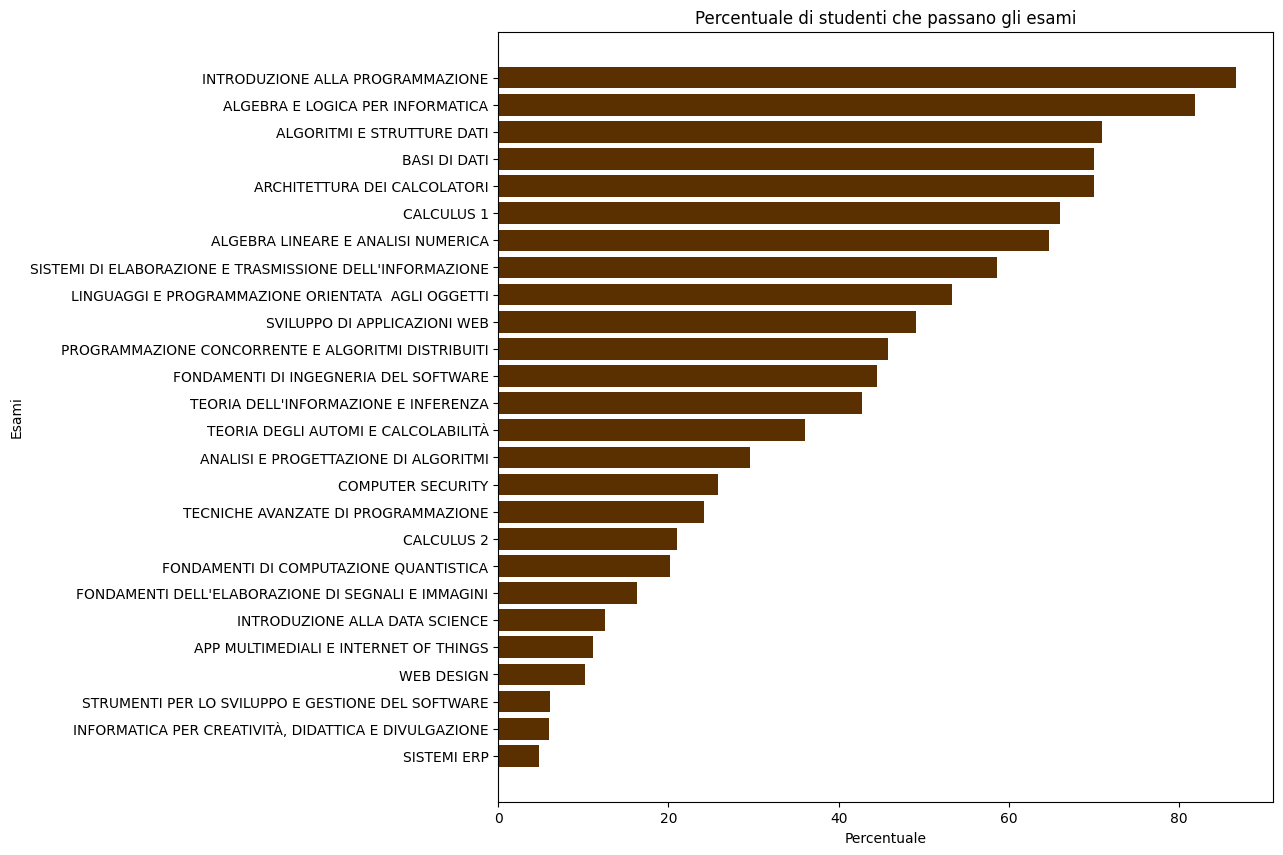

In [1080]:
# percentuale studenti per esame, su quelli nel database
perc =(pt_vecchi.groupby('DECODIFICA_INS').size() / pt_vecchi['PROGRESSIVO'].nunique()) *100

perc_sorted = perc.sort_values()
plt.figure(figsize=(10, 10))
bars = plt.barh(perc_sorted.index, perc_sorted, color='#5B3000')
plt.xlabel('Percentuale')
plt.ylabel('Esami')
plt.title('Percentuale di studenti che passano gli esami')
plt.show()

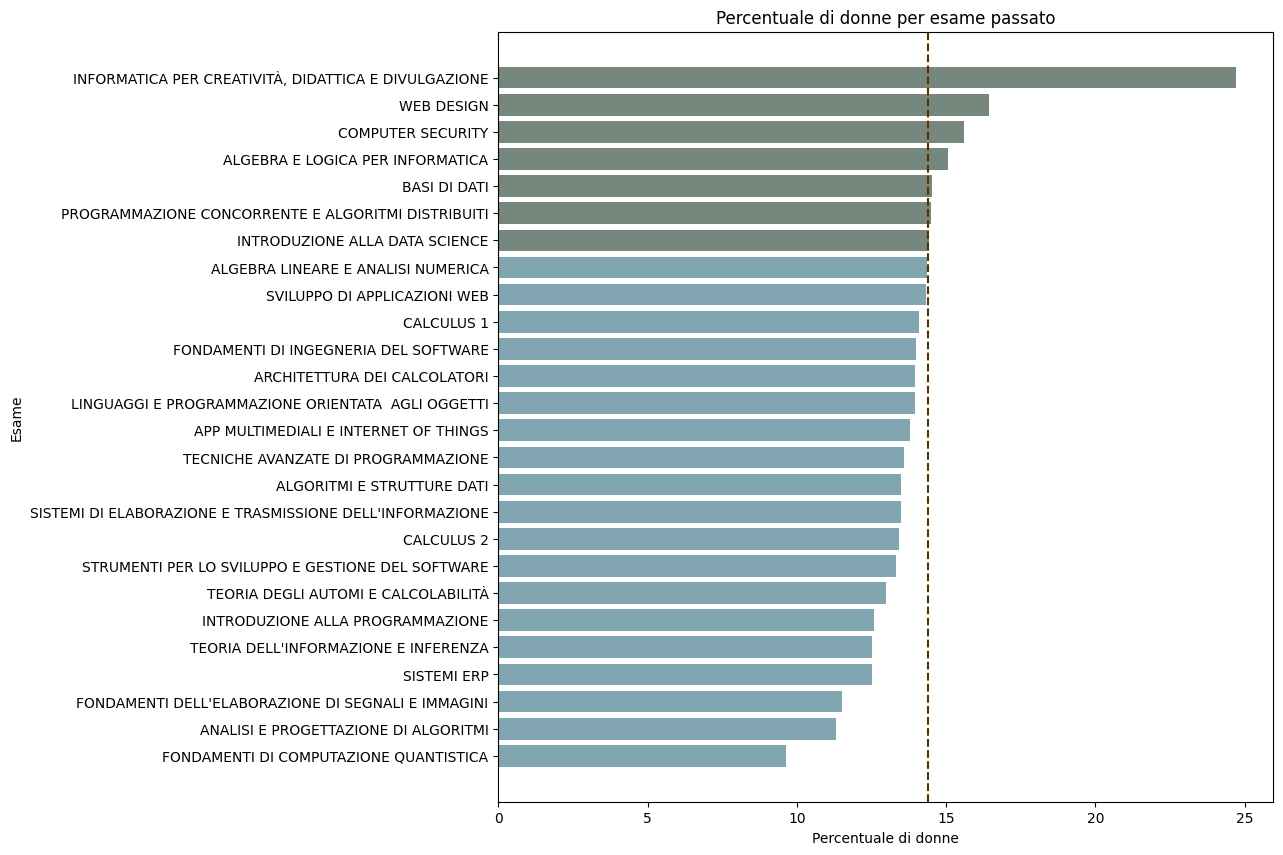

In [1081]:
# visualizzazione percentuale di donne sul numero totale, di persone che hanno superato l'esame
perc_donne = ((pt_vecchi[pt_vecchi['GENERE'] == 'F'].groupby('DECODIFICA_INS').size() / pt_vecchi.groupby('DECODIFICA_INS').size()) * 100)#.astype(int)

perc_donne_sorted = perc_donne.sort_values()
colors = ['#82A6B1' if val < 14.4 else '#76877D' for val in perc_donne_sorted]
plt.figure(figsize=(10, 10))
bars = plt.barh(perc_donne_sorted.index, perc_donne_sorted, color=colors)
plt.axvline(x=14.4, color='#5B3000', linestyle='--')
plt.xlabel('Percentuale di donne')
plt.ylabel('Esame')
plt.title('Percentuale di donne per esame passato')
plt.show()

In [1082]:
# la percentuale esami passati
totale_voti = len(pt)  # non ci sono null #print(pt['CODICE_INS'].isnull().sum()) #print(pt['VOTO'].isnull().sum())
totale_voti_donne = len(pt[pt['GENERE'] == 'F']) 
(totale_voti_donne/totale_voti)*100

13.79534944310558

Prcentuale di voti leggermente più bassa del numero di donne, posso assumere che si fermino prima degli uomini nel percorso?

### Percentuale di voti per ogni esame, divisi per genere

In [1083]:
# colori grafici
#colore_donne = '#F1C40F'
#colore_uomini = '#EF5B5B'

colore_donne = '#1ED074'
colore_uomini = '#FFA22E'

In [1084]:
# analizzo l'andamento generale dei voti per ogni esame (solo chi ha passato l'esame)
perc_voti = ((pt.groupby('VOTO').size()) / (totale_voti)) * 100

In [1085]:
# analizzo l'andamento per le donne dei voti
perc_voti_donne = ((pt[pt['GENERE'] == 'F'].groupby('VOTO').size()) / (totale_voti_donne)) * 100

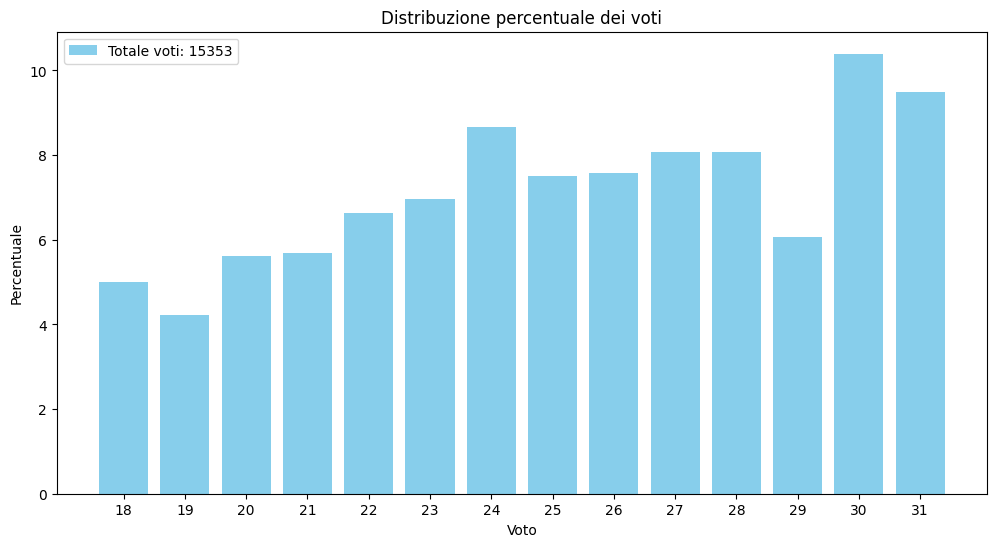

In [1086]:
totale_voti = len(pt) # uguale a pt_vecchi, entrambi senza null
voti = pt_vecchi['VOTO'].value_counts().sort_index()

percentuale_voti = (voti / totale_voti) * 100

plt.figure(figsize=(12, 6))
plt.bar(voti.index, percentuale_voti, color='skyblue', label=f'Totale voti: {totale_voti}')
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti')
plt.xticks(voti.index)

plt.legend()
plt.show()

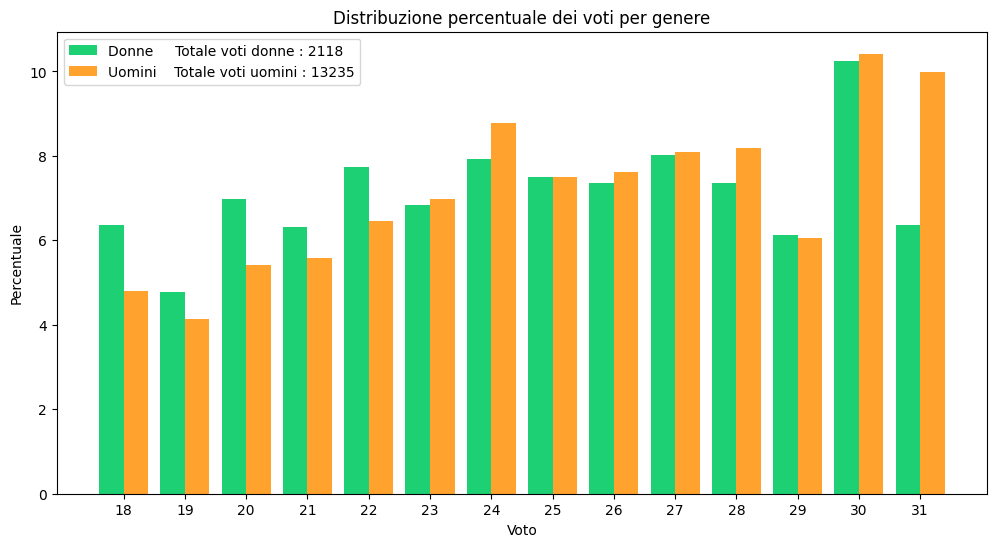

In [1087]:
# visualizzazione della percentuale dei voti per genere

totale_voti_donne = len(pt_vecchi[pt_vecchi['GENERE'] == 'F'])
totale_voti_uomini = len(pt_vecchi[pt_vecchi['GENERE'] == 'M'])

voti_donne = pt_vecchi[pt_vecchi['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = pt_vecchi[pt_vecchi['GENERE'] == 'M']['VOTO'].value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


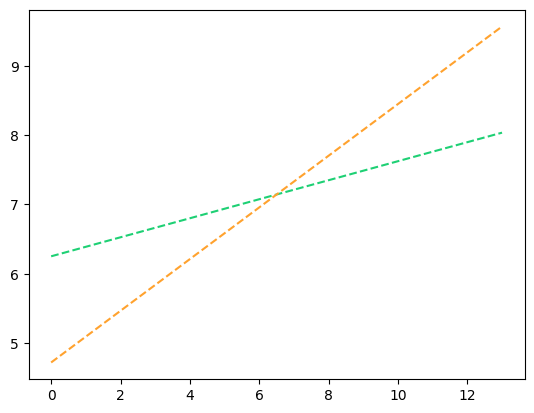

In [1088]:
# regressione lineare
# donne
slope_donne, intercept_donne, _, _, _ = linregress(r1, percentuale_voti_donne)
regressione_donne = slope_donne * np.array(r1) + intercept_donne
# uomini
slope_uomini, intercept_uomini, _, _, _ = linregress(r1, percentuale_voti_uomini)
regressione_uomini = slope_uomini * np.array(r1) + intercept_uomini

plt.plot(r1, regressione_donne, label='Regressione Donne', color=colore_donne, linestyle='--')
plt.plot(r1, regressione_uomini, label='Regressione Uomini', color=colore_uomini, linestyle='--')

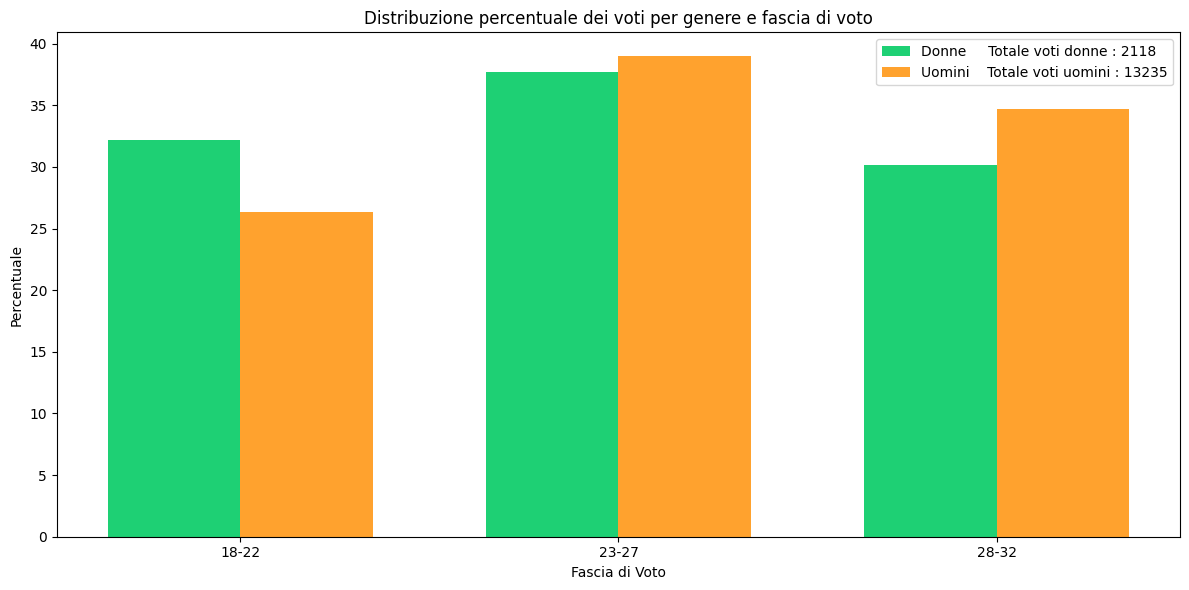

In [1089]:
totale_voti = pt_vecchi.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne, width=bar_width)
plt.bar(r2, percentuali_uomini, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini, width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()


Osservo che le donne prediligono voti inferiori rispetto agli uomini, in particolare per le lodi

In [1090]:
# percentuale di lauree 
n_laurea = len(pt_vecchi[pt_vecchi['CATEGORIA'] == 'laurea'].groupby('PROGRESSIVO'))
n_studenti = pt_vecchi['PROGRESSIVO'].nunique()
#print(f'numero di laureati: {n_laurea}')
#print(f'numero di studenti: {n_studenti}')
perc_laurea = round((n_laurea / n_studenti) * 100)
print(f"Percentuale laureati: {perc_laurea}%")

print()

# percentuale di donne laureate su totale laureati
n_laurea_donne = len(pt_vecchi[(pt_vecchi['CATEGORIA'] == 'laurea') & (pt_vecchi['GENERE'] == 'F')].groupby('PROGRESSIVO'))
#print(f'numero di donne laureate: {n_laurea_donne}')
perc_laurea = round((n_laurea_donne / n_laurea) * 100)
print(f"Percentuale donne laureate sul totale dei laureati: {perc_laurea}%")

# percentuale di donne laureate sul totale di donne
donne = pt_vecchi[pt_vecchi['GENERE'] == 'F']
n_donne = donne['PROGRESSIVO'].nunique()
perc_laurea = round((n_laurea_donne / n_donne) * 100)
print(f"Percentuale donne laureate sul totale donne: {perc_laurea}%")

print()

# percentuale di uomini laureate su totale laureati
n_laurea_uomini = len(pt_vecchi[(pt_vecchi['CATEGORIA'] == 'laurea') & (pt_vecchi['GENERE'] == 'M')].groupby('PROGRESSIVO'))
#print(f'numero di uomini laureati: {n_laurea_uomini}')
perc_laurea = round((n_laurea_uomini / n_laurea) * 100)
print(f"Percentuale uomini laureati sul totale dei laureati: {perc_laurea}%")

# percentuale di uomini laureate sul totale di uomini
uomini = pt_vecchi[pt_vecchi['GENERE'] == 'M']
n_uomini = uomini['PROGRESSIVO'].nunique()
perc_laurea = round((n_laurea_uomini / n_uomini) * 100)
print(f"Percentuale uomini laureati sul totale uomini: {perc_laurea}%")


Percentuale laureati: 37%

Percentuale donne laureate sul totale dei laureati: 14%
Percentuale donne laureate sul totale donne: 36%

Percentuale uomini laureati sul totale dei laureati: 86%
Percentuale uomini laureati sul totale uomini: 37%


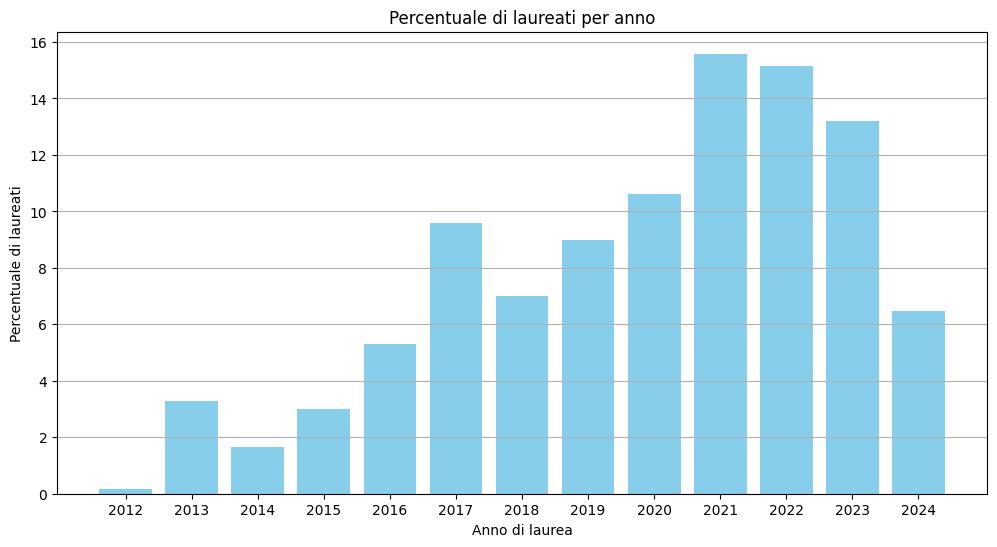

In [1091]:
totale_lauree = len(pt_vecchi[pt_vecchi['ANNO_LAUREA'].notna()])
laurea_per_anno = pt_vecchi[pt_vecchi['ANNO_LAUREA'].notna()]['ANNO_LAUREA'].value_counts().sort_index()

percentuale_laureati_per_anno = (laurea_per_anno / totale_lauree) * 100

plt.figure(figsize=(12, 6))
plt.bar(percentuale_laureati_per_anno.index, percentuale_laureati_per_anno, color='skyblue')
plt.xlabel('Anno di laurea')
plt.ylabel('Percentuale di laureati')
plt.title('Percentuale di laureati per anno')
plt.xticks(percentuale_laureati_per_anno.index)
plt.grid(axis='y')

plt.show()

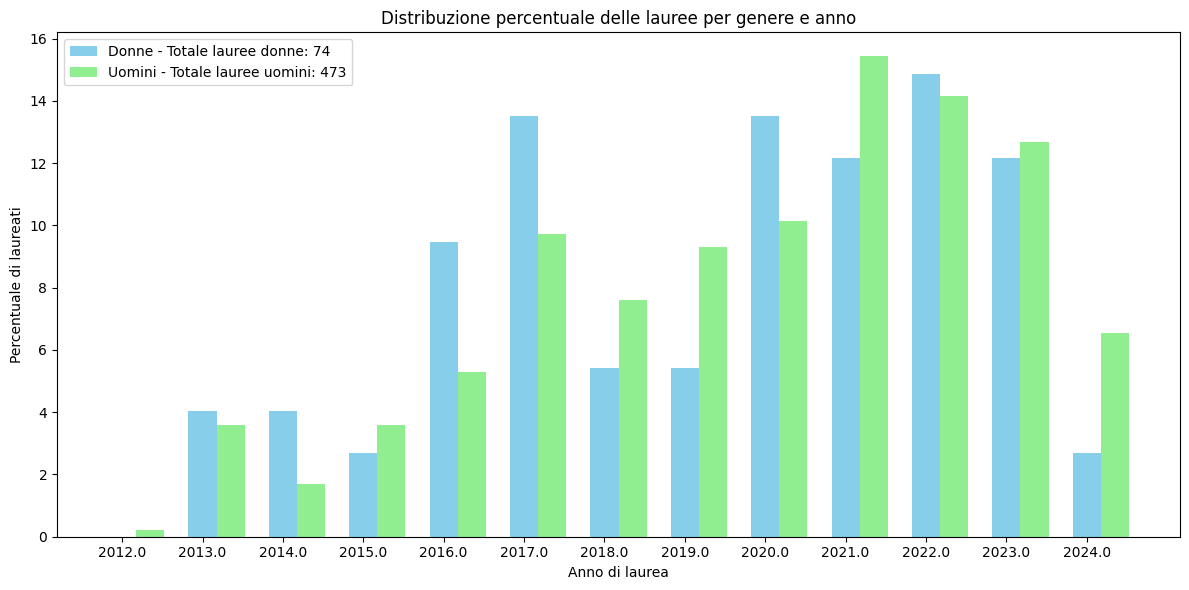

In [1092]:
totale_lauree_donne = len(pt_vecchi[(pt_vecchi['ANNO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'F')]['PROGRESSIVO'].unique())
totale_lauree_uomini = len(pt_vecchi[(pt_vecchi['ANNO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'M')]['PROGRESSIVO'].unique())

laurea_per_anno_donne = pt_vecchi[(pt_vecchi['ANNO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'F')].groupby('ANNO_LAUREA')['PROGRESSIVO'].nunique().sort_index()
laurea_per_anno_uomini = pt_vecchi[(pt_vecchi['ANNO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'M')].groupby('ANNO_LAUREA')['PROGRESSIVO'].nunique().sort_index()

anni = sorted(set(laurea_per_anno_donne.index).union(set(laurea_per_anno_uomini.index)))
laurea_per_anno_donne = laurea_per_anno_donne.reindex(anni, fill_value=0)
laurea_per_anno_uomini = laurea_per_anno_uomini.reindex(anni, fill_value=0)

percentuale_lauree_per_anno_donne = (laurea_per_anno_donne / totale_lauree_donne) * 100
percentuale_lauree_per_anno_uomini = (laurea_per_anno_uomini / totale_lauree_uomini) * 100

bar_width = 0.35
r1 = np.arange(len(anni))
r2 = [x + bar_width for x in r1]
plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_lauree_per_anno_donne, width=bar_width, label=f'Donne - Totale lauree donne: {totale_lauree_donne}', color='skyblue')
plt.bar(r2, percentuale_lauree_per_anno_uomini, width=bar_width, label=f'Uomini - Totale lauree uomini: {totale_lauree_uomini}', color='lightgreen')
plt.xlabel('Anno di laurea')
plt.ylabel('Percentuale di laureati')
plt.title('Distribuzione percentuale delle lauree per genere e anno')
plt.xticks(r1, anni)
plt.legend()

plt.tight_layout()
plt.show()

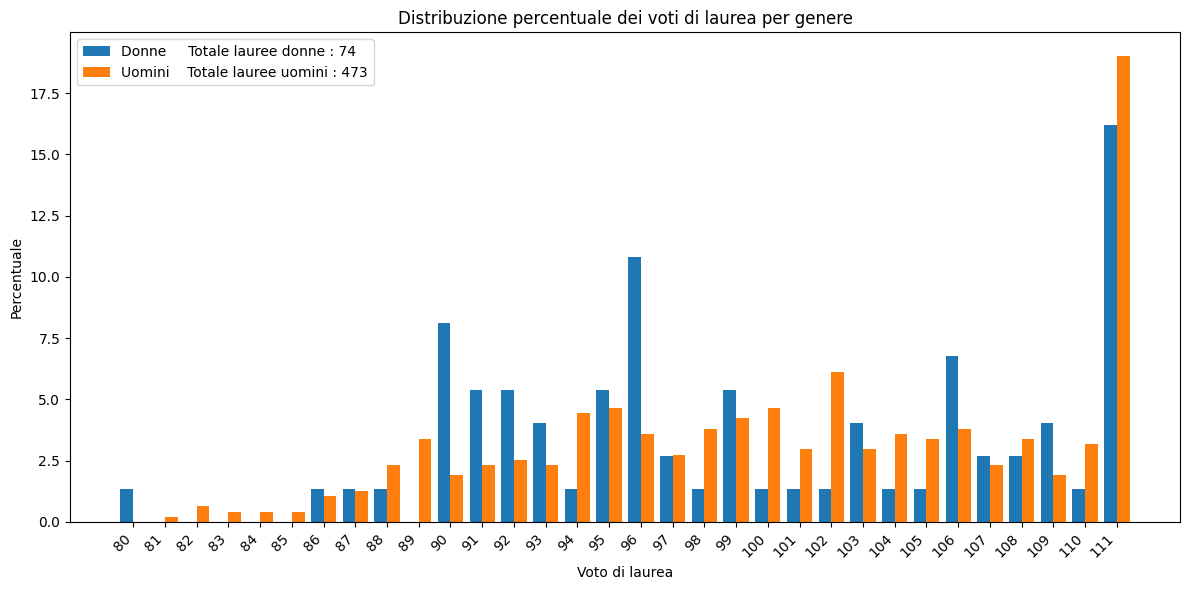

In [1093]:
totale_lauree_donne = len(pt_vecchi[(pt_vecchi['VOTO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'F')]['PROGRESSIVO'].unique())
totale_lauree_uomini = len(pt_vecchi[(pt_vecchi['VOTO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'M')]['PROGRESSIVO'].unique())

voti_l_donne = pt_vecchi[pt_vecchi['GENERE'] == 'F'].groupby('PROGRESSIVO')['VOTO_LAUREA'].mean().round().value_counts().sort_index()
voti_l_uomini = pt_vecchi[pt_vecchi['GENERE'] == 'M'].groupby('PROGRESSIVO')['VOTO_LAUREA'].mean().round().value_counts().sort_index()

voti_l = sorted(set(voti_l_donne.index).union(set(voti_l_uomini.index)))
voti_l_donne = voti_l_donne.reindex(voti_l, fill_value=0)
voti_l_uomini = voti_l_uomini.reindex(voti_l, fill_value=0)

percentuale_voti_l_donne = (voti_l_donne / totale_lauree_donne) * 100
percentuale_voti_l_uomini = (voti_l_uomini / totale_lauree_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti_l))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_l_donne, width=bar_width, label=f'Donne     Totale lauree donne : {totale_lauree_donne}')
plt.bar(r2, percentuale_voti_l_uomini, width=bar_width, label=f'Uomini    Totale lauree uomini : {totale_lauree_uomini}')
plt.xlabel('Voto di laurea')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti di laurea per genere')
plt.legend()

plt.xticks([r + bar_width/2 for r in range(len(voti_l))], [int(v) for v in voti_l])
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()

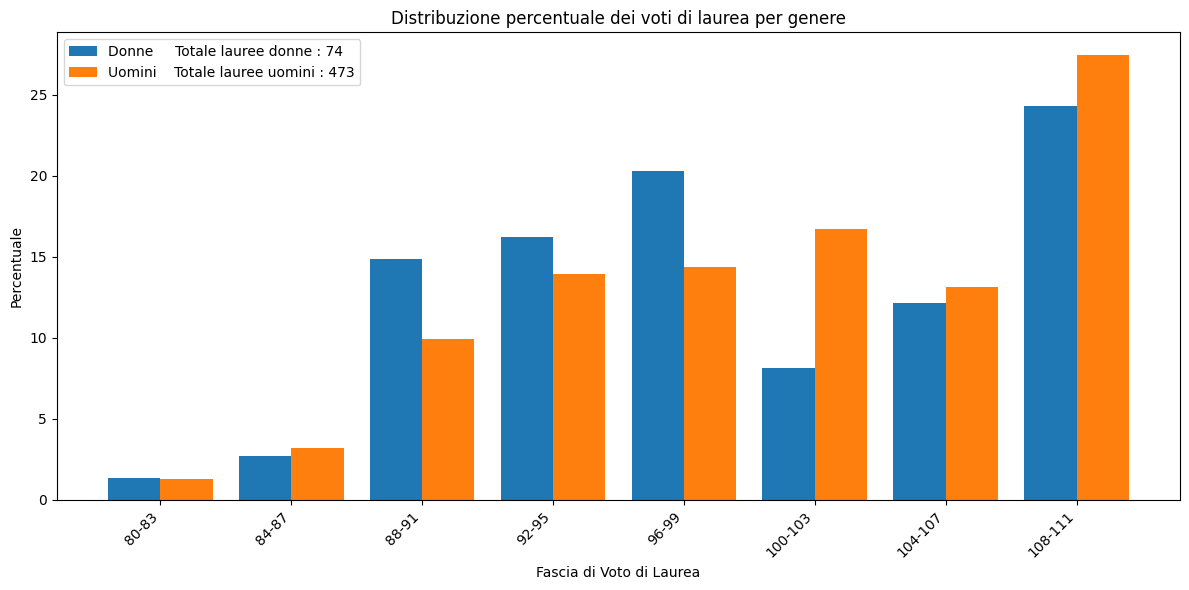

In [1094]:
totale_lauree_donne = len(pt_vecchi[(pt_vecchi['VOTO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'F')]['PROGRESSIVO'].unique())
totale_lauree_uomini = len(pt_vecchi[(pt_vecchi['VOTO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'M')]['PROGRESSIVO'].unique())

# Calcolo della distribuzione dei voti per fascia per genere
voti_l_donne = pt_vecchi[(pt_vecchi['GENERE'] == 'F') & (pt_vecchi['VOTO_LAUREA'].notna())].groupby('PROGRESSIVO')['FASCIA_VOTO_LAUREA'].first().value_counts().sort_index()
voti_l_uomini = pt_vecchi[(pt_vecchi['GENERE'] == 'M') & (pt_vecchi['VOTO_LAUREA'].notna())].groupby('PROGRESSIVO')['FASCIA_VOTO_LAUREA'].first().value_counts().sort_index()

# Ordinamento delle fasce di voto
fasce_voto_ordinate = ['80-83', '84-87', '88-91', '92-95', '96-99', '100-103', '104-107', '108-111']
voti_l_donne = voti_l_donne.reindex(fasce_voto_ordinate, fill_value=0)
voti_l_uomini = voti_l_uomini.reindex(fasce_voto_ordinate, fill_value=0)

# Calcolo delle percentuali
percentuale_voti_l_donne = (voti_l_donne / totale_lauree_donne) * 100
percentuale_voti_l_uomini = (voti_l_uomini / totale_lauree_uomini) * 100

# Creazione del grafico a barre
bar_width = 0.4
r1 = np.arange(len(fasce_voto_ordinate))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_l_donne, width=bar_width, label=f'Donne     Totale lauree donne : {totale_lauree_donne}')
plt.bar(r2, percentuale_voti_l_uomini, width=bar_width, label=f'Uomini    Totale lauree uomini : {totale_lauree_uomini}')
plt.xlabel('Fascia di Voto di Laurea')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti di laurea per genere')
plt.legend()

plt.xticks([r + bar_width/2 for r in range(len(fasce_voto_ordinate))], fasce_voto_ordinate, rotation=45, ha='right')

plt.tight_layout()
plt.show()

Il campione delle donne è basso, per dare conclusioni <br>
Il trend è sempre lo stesso, sotto il 100 i voti sono a favore delle donne mentre sopra sono a favore degli uomini

### Periodo preciso, pandemia
analizzo un periodo temporale preciso, il periodo di pandemia, in cui le modalità di esame sono cambiate per tutti gli insegnamenti <br>
inizio: 11 marzo 2020 <br>
non ho una data precisa della fine del periodo, perchè dipende dall'università, dal dipartimento e dal singolo professore <br>
indicativamente le sessioni con modalità d'esame completamente online sono state quelle estive giugno, luglio, settemrbe) del 2020 e quella invernale (gennaio, febbraio) del 2021 <br>
questo per quanto riguarda il dipartimento di informatica, <br>
successivamente alcuni professori hanno mantenuto alcune modalità online, come quiz o orali

In [1095]:
# periodo pandemia : marzo 2020 - marzo 2021

data_inizio = '2020-03-11' #anno-mese-giorno
data_fine = '2021-03-11'
periodo_pandemia = pt_vecchi[pt_vecchi['DATA_ESAME'].between(data_inizio, data_fine)]

NON_periodo_pandemia = pt_vecchi[~pt_vecchi['DATA_ESAME'].between(data_inizio, data_fine)]

In [1096]:
media_voti = round(pt['VOTO'].mean(), 2)
media_voti_p_p = round(periodo_pandemia['VOTO'].mean(), 2)
media_voti_N_p_p = round(NON_periodo_pandemia['VOTO'].mean(), 2)

print(f"Media valutazioni: {media_voti}")
print(f"Media valutazioni periodo di pandemia: {media_voti_p_p}")
print(f"Media valutazioni escluso il periodo di pandemia: {media_voti_N_p_p}")


Media valutazioni: 25.27
Media valutazioni periodo di pandemia: 25.15
Media valutazioni escluso il periodo di pandemia: 25.29


Le medie si discostano in modo NON significativo nei diversi periodi

In [1097]:
donne = pt_vecchi[pt_vecchi['GENERE'] == 'F']
uomini = pt_vecchi[pt_vecchi['GENERE'] == 'M']

donne_p_p = periodo_pandemia[periodo_pandemia['GENERE'] == 'F']
uomini_p_p = periodo_pandemia[periodo_pandemia['GENERE'] == 'M']

print("Media valutazioni")
media_voti = round(donne['VOTO'].mean(), 2)
print(f"Donne: {media_voti}")
media_voti = round(uomini['VOTO'].mean(), 2)
print(f"Uomini: {media_voti}")
print()
print("Media valutazioni periodo di pandemia")
media_voti_p_p = round(donne_p_p['VOTO'].mean(), 2)
print(f"Donne: {media_voti_p_p}")
media_voti_p_p = round(uomini_p_p['VOTO'].mean(), 2)
print(f"Uomini: {media_voti_p_p}")

Media valutazioni
Donne: 24.81
Uomini: 25.35

Media valutazioni periodo di pandemia
Donne: 24.77
Uomini: 25.21


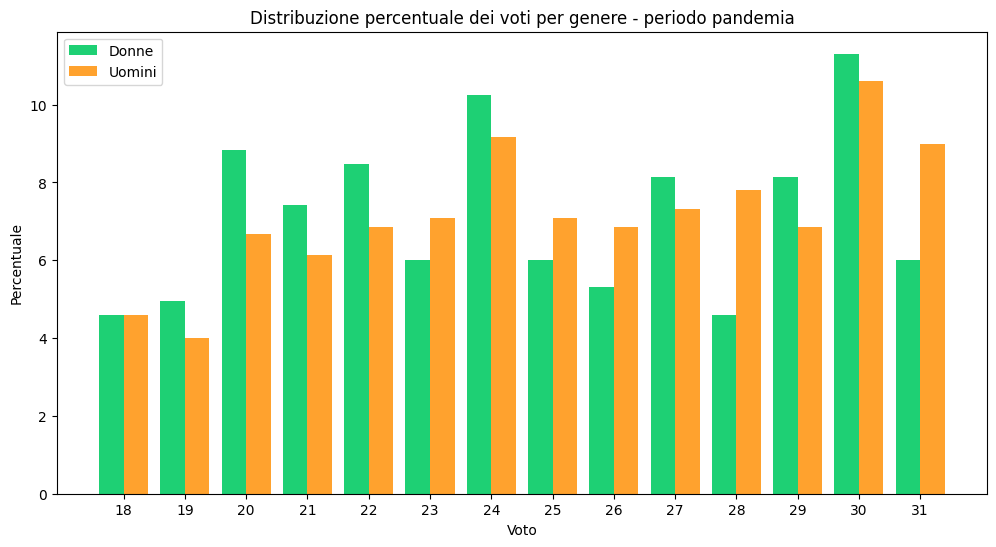

In [1098]:
# visualizzazione della percentuale dei voti per genere

voti_donne = periodo_pandemia[periodo_pandemia['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = periodo_pandemia[periodo_pandemia['GENERE'] == 'M']['VOTO'].value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / len(periodo_pandemia[periodo_pandemia['GENERE'] == 'F'])) * 100
percentuale_voti_uomini = (voti_uomini / len(periodo_pandemia[periodo_pandemia['GENERE'] == 'M'])) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label='Donne', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label='Uomini', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere - periodo pandemia')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


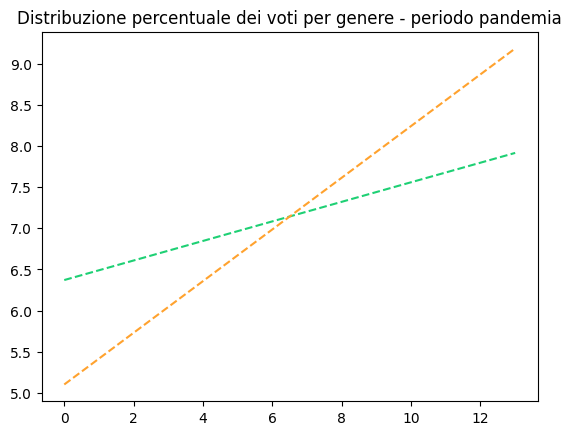

In [1099]:
# regressione lineare
# donne
slope_donne, intercept_donne, _, _, _ = linregress(r1, percentuale_voti_donne)
regressione_donne = slope_donne * np.array(r1) + intercept_donne
# uomini
slope_uomini, intercept_uomini, _, _, _ = linregress(r1, percentuale_voti_uomini)
regressione_uomini = slope_uomini * np.array(r1) + intercept_uomini
plt.title('Distribuzione percentuale dei voti per genere - periodo pandemia')
plt.plot(r1, regressione_donne, label='Regressione Donne', color=colore_donne, linestyle='--')
plt.plot(r1, regressione_uomini, label='Regressione Uomini', color=colore_uomini, linestyle='--')


### Il periodo di pandemia ha inciso in generale sui singoli voti
In generale è aumentato il divario di genere guardando singolarmente i voti <br>
L'andamento degli uomini è cambiato meno rispetto a quello delle donne <br> -- non so se posso affermarlo stando a questi dati
per le donne sono diminuiti i 18 e aumentati i 20, 22, 24 <br>
Per gli uomini sono aumentati i 32 <br>

In generale le valutazioni si sono alzate, ma la media è rimasta costante
Questi risultati possono essere dati dalla scarsità del campione per quanto riguarda le donne

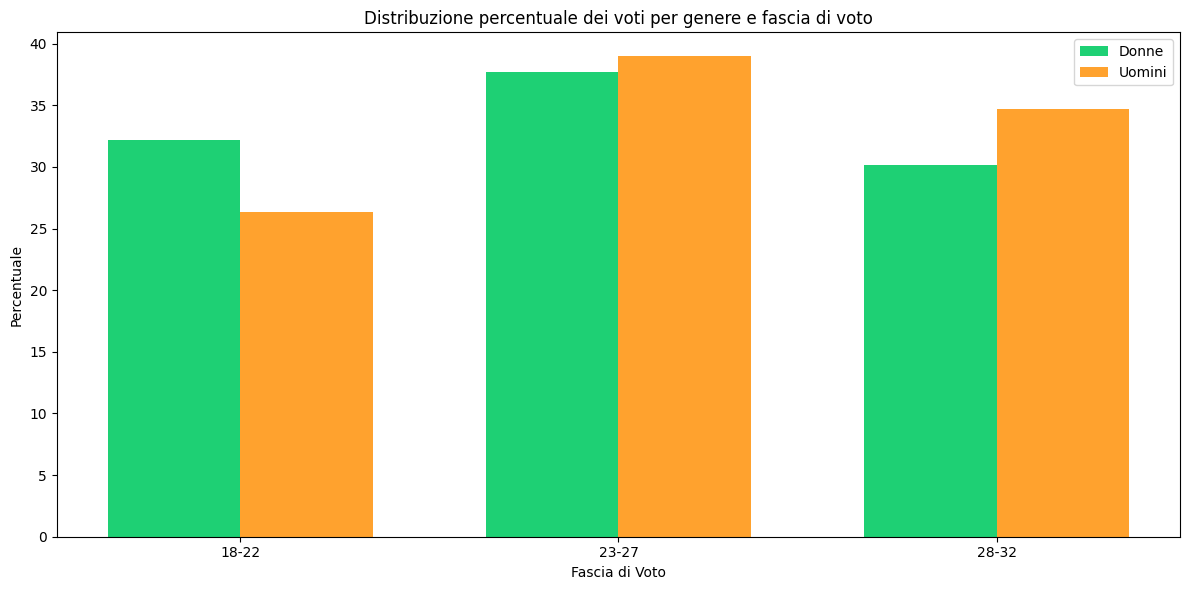

In [1100]:
totale_voti = pt_vecchi.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label='Donne', color=colore_donne, width=bar_width)
plt.bar(r2, percentuali_uomini, label='Uomini', color=colore_uomini, width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()


### Analizzo singolarmente alcuni insegnamenti con una sola modalità di esame
per ora assumo che anche i vecchi insegnamenti avessero le modalità riportate<br>
<br>
Esami orali: 
<br>
<b>SETI</b>: quiz sbarramento + orale <br>
<b>APA</b>: scritto sbarramento + orale di 2 professori <br>
<b>SAW</b>:  domande sbarramento + orale progetto <br>
<b>TAC</b>: scritto sbarramento + orale <br>
<b>FCQ</b>: solo orale <br>


<br>
Esami scritti: <br>
<b>Algebra e logica</b>: 2 scritti <br>
<b>ALAN</b>: due scritti <br>
<b>TDII</b>: solo scritto <br>
<b>CALCULUS2</b>: solo scritto <br>
<b>CS</b>: solo scritto <br>
<b>PCAD</b>: solo scritto<br>
<b>FIS</b>: quiz sbarramento + due scritti <br>


In [1101]:
# orali
media_orali = round(esami_orali['VOTO'].mean(), 2)
print(f"Media valutazioni esami orali: {media_orali}")

donne = esami_orali[esami_orali['GENERE'] == 'F']
media_orali = round(donne['VOTO'].mean(), 2)
print(f"Media valutazioni esami orali delle donne: {media_orali}")

uomini = esami_orali[esami_orali['GENERE'] == 'M']
media_orali = round(uomini['VOTO'].mean(), 2)
print(f"Media valutazioni esami orali degli uomini: {media_orali}")

# scritti
media_scritti = round(esami_scritti['VOTO'].mean(), 2)
print(f"Media valutazioni esami scritti: {media_scritti}")

donne = esami_scritti[esami_scritti['GENERE'] == 'F']
media_orali = round(donne['VOTO'].mean(), 2)
print(f"Media valutazioni esami orali delle donne: {media_orali}")

uomini = esami_scritti[esami_scritti['GENERE'] == 'M']
media_orali = round(uomini['VOTO'].mean(), 2)
print(f"Media valutazioni esami orali degli uomini: {media_orali}")

Media valutazioni esami orali: 25.9
Media valutazioni esami orali delle donne: 25.48
Media valutazioni esami orali degli uomini: 25.96
Media valutazioni esami scritti: 24.19
Media valutazioni esami orali delle donne: 23.58
Media valutazioni esami orali degli uomini: 24.29


la media si discosta più tra scritti e orali rispetto che alla differenza di genere

/tmp/ipykernel_3894/2444232092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esami_scritti['TIPO_ESAME'] = 'SCRITTI'
/tmp/ipykernel_3894/2444232092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esami_orali['TIPO_ESAME'] = 'ORALI'


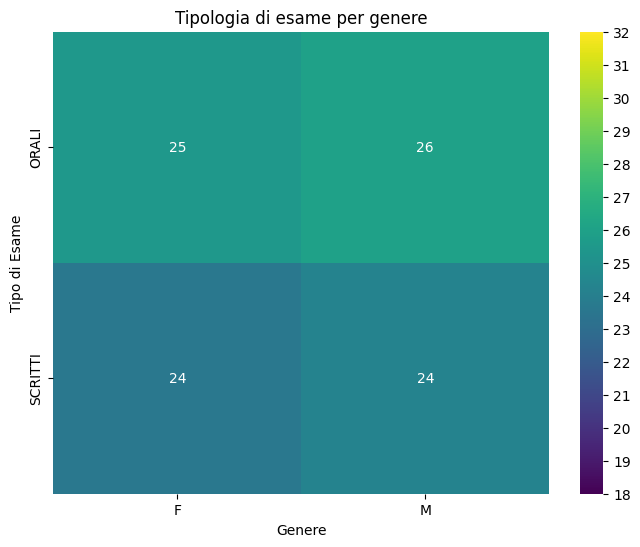

In [1102]:
# creo nuovo db esami per non gestire null
esami_scritti['TIPO_ESAME'] = 'SCRITTI'
esami_orali['TIPO_ESAME'] = 'ORALI'
esami = pd.concat([esami_scritti, esami_orali])

pivot_table = esami.pivot_table(values='VOTO', index='TIPO_ESAME', columns='GENERE', aggfunc='mean')
cbar_kws = {'ticks': range(18, 33)}
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(pivot_table, annot=True, cmap='viridis', vmin=18, vmax=32, cbar_kws=cbar_kws)
heatmap.set_title('Tipologia di esame per genere')
plt.xlabel('Genere')
plt.ylabel('Tipo di Esame')
plt.show()

La differenza delle medie non è significativa, la media delle donne è sempre leggermente inferiore a quella maschile
E' maggiormente evidente che la media degli scritti è inferiore a quella degli orali

### Esami orali

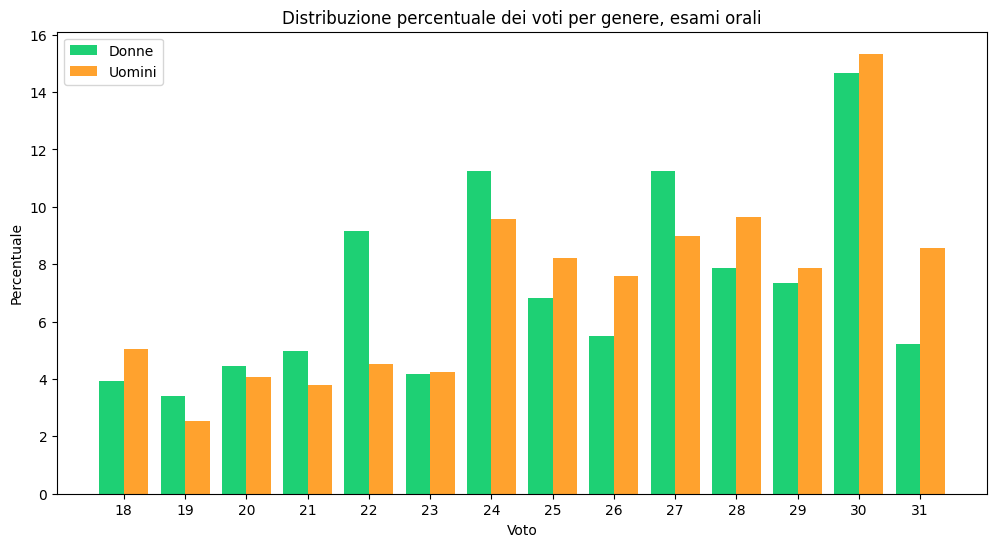

In [1103]:
# distribuzione dei voti orali

totale_voti_donne = len(esami_orali[esami_orali['GENERE'] == 'F'])
totale_voti_uomini = len(esami_orali[esami_orali['GENERE'] == 'M'])
voti_donne = esami_orali[esami_orali['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = esami_orali[esami_orali['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label='Donne', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label='Uomini', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere, esami orali')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


Text(0.5, 1.0, 'Distribuzione percentuale dei voti per genere, esami orali')

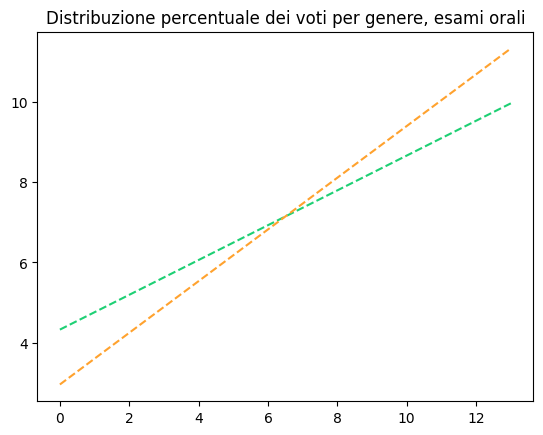

In [1104]:
# regressione lineare
# donne
slope_donne, intercept_donne, _, _, _ = linregress(r1, percentuale_voti_donne)
regressione_donne = slope_donne * np.array(r1) + intercept_donne
# uomini
slope_uomini, intercept_uomini, _, _, _ = linregress(r1, percentuale_voti_uomini)
regressione_uomini = slope_uomini * np.array(r1) + intercept_uomini

plt.plot(r1, regressione_donne, label='Regressione Donne', color=colore_donne, linestyle='--')
plt.plot(r1, regressione_uomini, label='Regressione Uomini', color=colore_uomini, linestyle='--')
plt.title('Distribuzione percentuale dei voti per genere, esami orali')

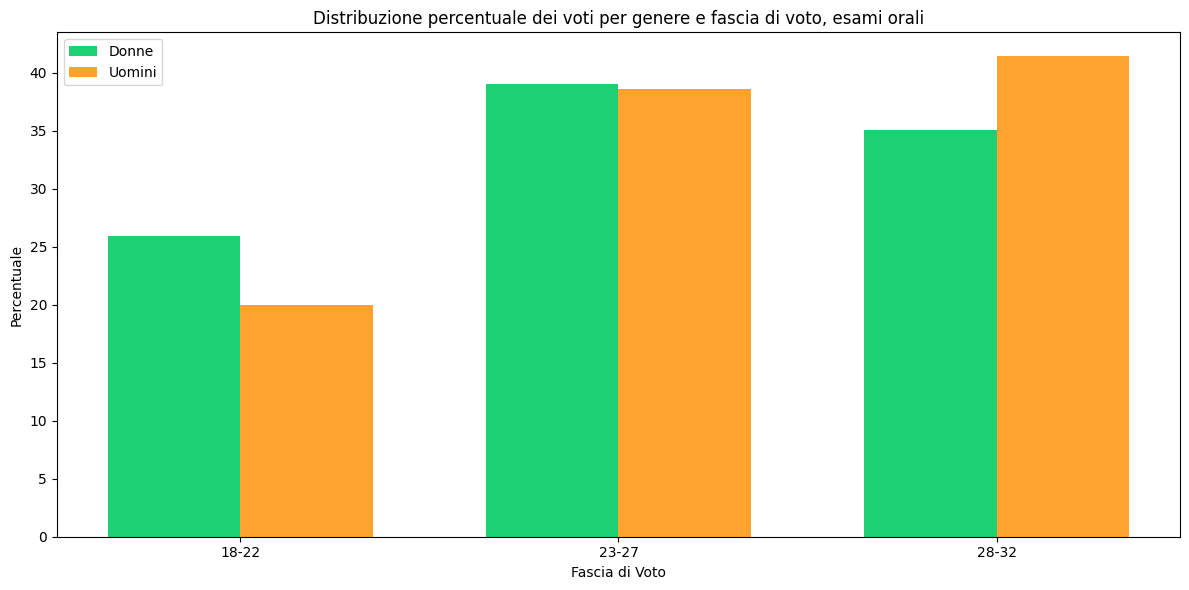

In [1105]:
totale_voti = esami_orali.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label='Donne', color=colore_donne, width=bar_width)
plt.bar(r2, percentuali_uomini, label='Uomini', color=colore_uomini, width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto, esami orali')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()

### Esami scritti

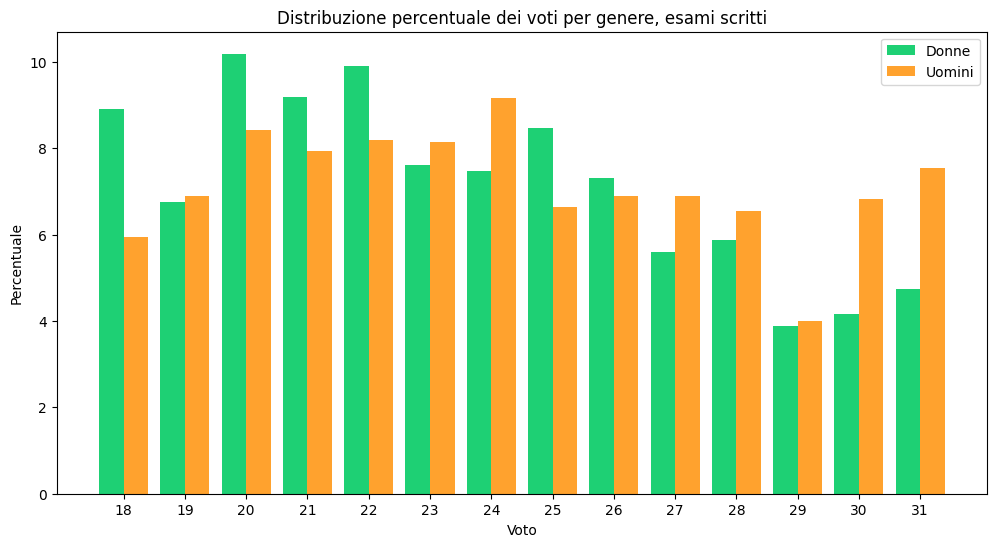

In [1111]:
# distribuzione dei voti scritti

totale_voti_donne = len(esami_scritti[esami_scritti['GENERE'] == 'F'])
totale_voti_uomini = len(esami_scritti[esami_scritti['GENERE'] == 'M'])
voti_donne = esami_scritti[esami_scritti['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = esami_scritti[esami_scritti['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label='Donne', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label='Uomini', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere, esami scritti')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


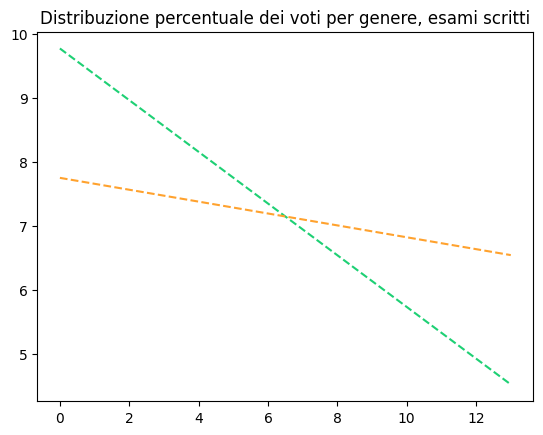

In [1115]:
# regressione lineare
# donne
slope_donne, intercept_donne, _, _, _ = linregress(r1, percentuale_voti_donne)
regressione_donne = slope_donne * np.array(r1) + intercept_donne
# uomini
slope_uomini, intercept_uomini, _, _, _ = linregress(r1, percentuale_voti_uomini)
regressione_uomini = slope_uomini * np.array(r1) + intercept_uomini

plt.title('Distribuzione percentuale dei voti per genere, esami scritti')
plt.plot(r1, regressione_donne, label='Regressione Donne', color=colore_donne, linestyle='--')
plt.plot(r1, regressione_uomini, label='Regressione Uomini', color=colore_uomini, linestyle='--')


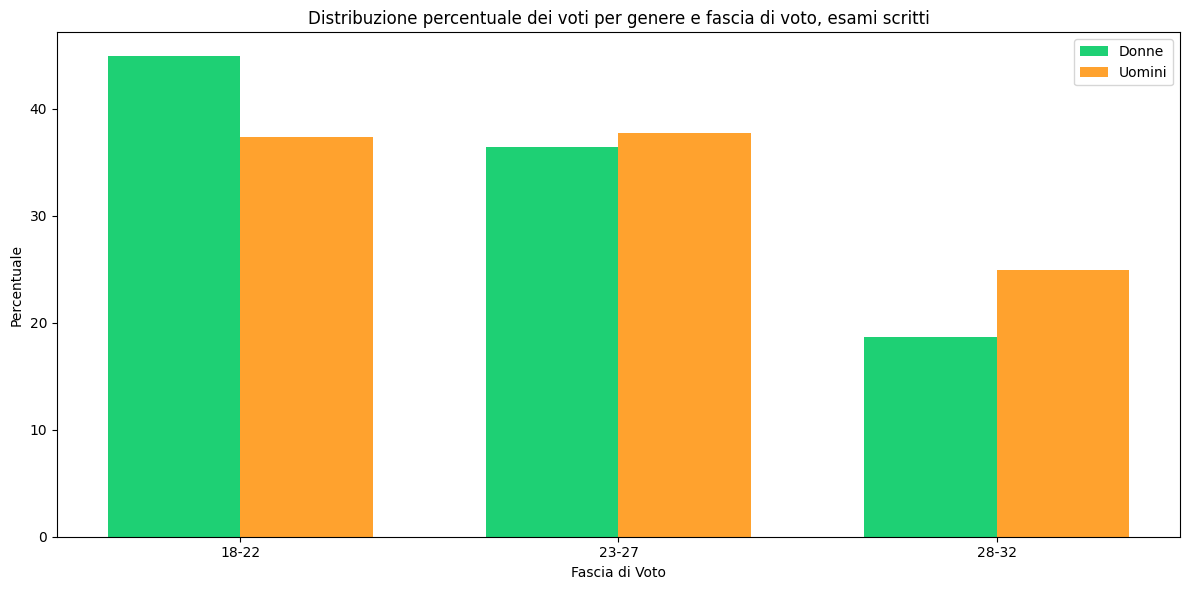

In [1116]:
totale_voti = esami_scritti.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label='Donne', color=colore_donne, width=bar_width)
plt.bar(r2, percentuali_uomini, label='Uomini', color=colore_uomini, width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto, esami scritti')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()


### Singoli esami

In [1136]:
# Analizzo un esame in particolare

# sbilanciati
# CALCULUS 2 
# SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE
# TECNICHE AVANZATE DI PROGRAMMAZIONE

# bilanciati
# ALGORITMI E STRUTTURE DATI

nome_esame = 'TECNICHE AVANZATE DI PROGRAMMAZIONE'

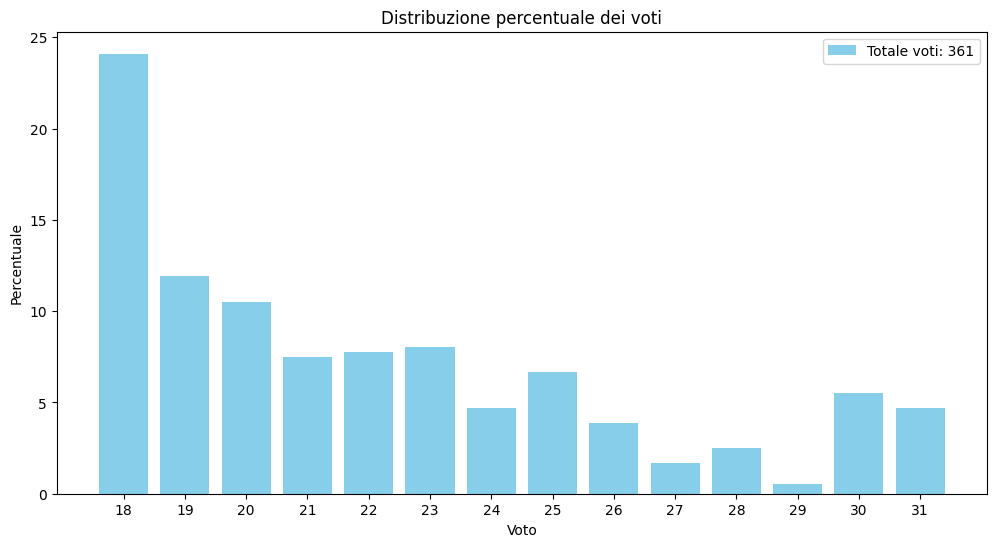

In [1137]:
esame_singolo = pt_vecchi[pt_vecchi['DECODIFICA_INS'] == nome_esame]

totale_voti = len(esame_singolo)
voti = esame_singolo['VOTO'].value_counts().sort_index()

percentuale_voti = (voti / totale_voti) * 100

plt.figure(figsize=(12, 6))
plt.legend([f'Totale voti: {totale_voti}'])
plt.bar(voti.index, percentuale_voti, color='skyblue', label=f'Totale voti: {totale_voti}')
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti')
plt.xticks(voti.index)

plt.legend()
plt.show()

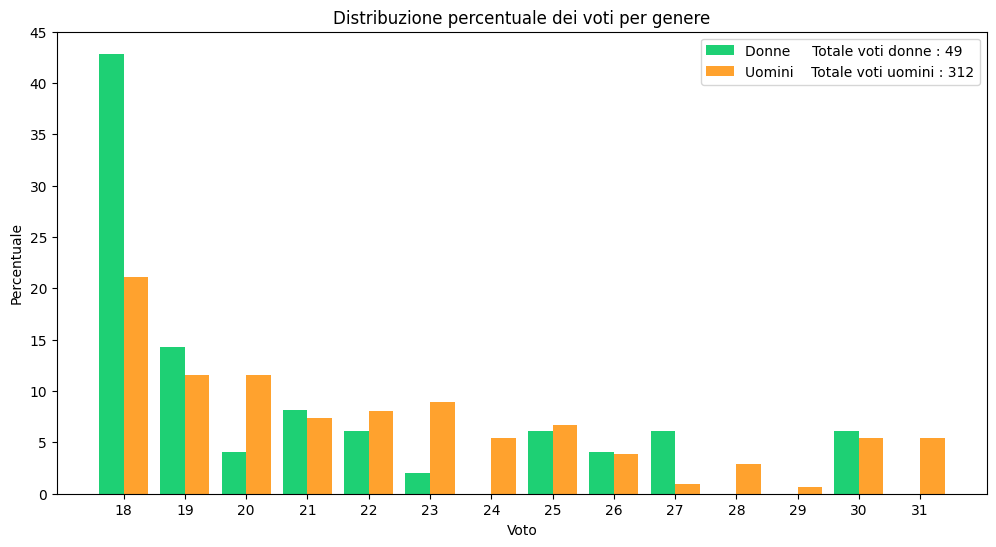

In [1138]:
esame_singolo = pt_vecchi[(pt_vecchi['DECODIFICA_INS'] == nome_esame)]

totale_voti_donne = len(esame_singolo[esame_singolo['GENERE'] == 'F'])
totale_voti_uomini = len(esame_singolo[esame_singolo['GENERE'] == 'M'])
voti_donne = esame_singolo[esame_singolo['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = esame_singolo[esame_singolo['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color= colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere')
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.legend()
plt.show()

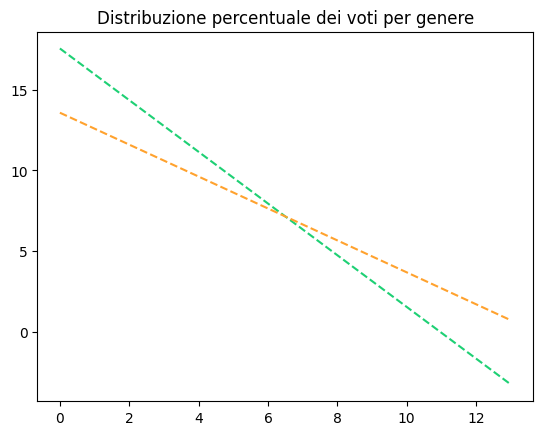

In [1139]:
# regressione lineare
# donne
slope_donne, intercept_donne, _, _, _ = linregress(r1, percentuale_voti_donne)
regressione_donne = slope_donne * np.array(r1) + intercept_donne
# uomini
slope_uomini, intercept_uomini, _, _, _ = linregress(r1, percentuale_voti_uomini)
regressione_uomini = slope_uomini * np.array(r1) + intercept_uomini

plt.title('Distribuzione percentuale dei voti per genere')
plt.plot(r1, regressione_donne, label='Regressione Donne', color=colore_donne, linestyle='--')
plt.plot(r1, regressione_uomini, label='Regressione Uomini', color=colore_uomini, linestyle='--')